In [154]:
import os
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,InputLayer
from keras.layers import Conv2D, MaxPooling2D, Lambda
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import csv
import cv2
import scipy
%matplotlib inline
import matplotlib.pyplot as plt


In [155]:
#PARAMETERS SETTING

DAMPING_FACTOR = 10
PHASE_SHIFT =0
DELTA_FREQUENCY =123.2
DELTA_BETA = 0
DELTA_ALPHA =-0.026
NDP =2048
LEARNING_RATE =0.001

In [156]:
df = pd.read_csv("./mrs_datasets.csv")

In [157]:
df.head()

,imag_component,real_component,ace_imag,ace_real,ala_imag,ala_real,asc_imag,asc_real,asp_imag,asp_real,...,naag_imag,naag_real,pcho_imag,pcho_real,pcr_imag,pcr_real,pe_imag,pe_real,tau_imag,tau_real
0,103.39270,267.478460,0.00000,3.100000,0.034923,2.769480,0.008175,3.83645,-0.070215,2.153580,...,-0.224074,8.76237,-0.000002,12.14190,0.00000,5.10000,-0.000055,3.01880,-3.000000e-07,3.92162
1,208.88067,475.039650,-1.59678,2.643850,-1.425420,2.328820,-0.535391,3.75273,-0.743603,1.964530,...,-3.729120,7.74945,-3.015710,11.70030,-1.27955,4.88867,-0.671965,2.93129,-1.041460e+00,3.74859
2,362.25272,321.308610,-2.71081,1.430540,-2.352400,1.147570,-1.004860,3.55094,-1.264100,1.545000,...,-6.319120,5.24486,-5.756960,10.46610,-2.40047,4.31520,-1.258190,2.66288,-1.954820e+00,3.28968
3,427.01000,128.034040,-3.02747,-0.162387,-2.426660,-0.310499,-1.374670,3.29898,-1.561160,1.006050,...,-7.413620,1.89018,-8.019600,8.59008,-3.26274,3.48772,-1.712500,2.28873,-2.667710e+00,2.63528
4,382.59452,-45.193075,-2.48820,-1.662300,-1.670910,-1.495770,-1.675670,3.05325,-1.641010,0.461769,...,-6.829890,-1.49316,-9.685960,6.25744,-3.83935,2.52442,-2.048340,1.87846,-3.172140e+00,1.87632


In [158]:
df.describe()

,imag_component,real_component,ace_imag,ace_real,ala_imag,ala_real,asc_imag,asc_real,asp_imag,asp_real,...,naag_imag,naag_real,pcho_imag,pcho_real,pcr_imag,pcr_real,pe_imag,pe_real,tau_imag,tau_real
count,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,...,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000,2048.000000
mean,0.888362,0.022842,-0.002747,0.000878,-0.002801,0.000771,-0.024353,0.002056,-0.004036,0.000645,...,-0.020442,-0.015210,-0.026423,0.003639,-0.011812,0.001788,-0.008142,0.000560,-0.007346,0.001000
std,20.312742,19.385899,0.836298,0.837712,0.527957,0.529806,0.428493,0.434801,0.216379,0.218922,...,0.966210,0.980368,2.524436,2.531886,1.004969,1.008287,0.291489,0.294802,0.434440,0.438984
min,-79.653652,-214.828250,-3.027470,-2.970990,-2.426660,-2.206440,-2.919780,-2.102230,-1.641010,-1.525520,...,-7.413620,-5.466440,-11.051500,-9.235690,-4.220290,-4.303890,-2.668320,-1.683720,-3.656880,-3.617810
25%,-3.272611,-3.555623,-0.322057,-0.319175,-0.178390,-0.176367,-0.120600,-0.109261,-0.068676,-0.066385,...,-0.335157,-0.325655,-0.984788,-0.985895,-0.328275,-0.329649,-0.074193,-0.077719,-0.064095,-0.066167
50%,0.203375,-0.032878,-0.000143,0.001086,-0.000985,-0.000642,0.000722,0.000665,0.001977,-0.000242,...,-0.014061,-0.002871,-0.014287,0.001951,-0.001874,0.001041,-0.001151,0.000276,-0.000173,-0.000353
75%,3.393012,3.135960,0.319927,0.324569,0.170996,0.172634,0.111238,0.123372,0.068849,0.065565,...,0.307591,0.299814,0.947504,0.975601,0.319130,0.328891,0.073650,0.075345,0.065186,0.067182
max,427.010000,475.039650,2.855430,3.100000,2.055490,2.769480,1.477380,3.836450,1.261670,2.153580,...,5.522700,8.762370,8.414550,12.141900,4.700240,5.100000,1.975330,3.018800,3.474780,3.921620


In [159]:
#Plots of the real part of FID Signals of selected metabolites
#Notice it is decaying

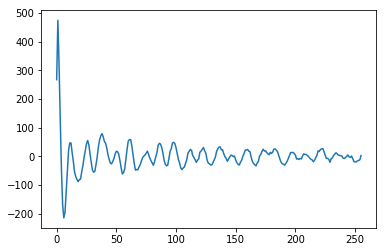

In [160]:
real_component_truncated = df.real_component[:256]
plt.plot(real_component_truncated)

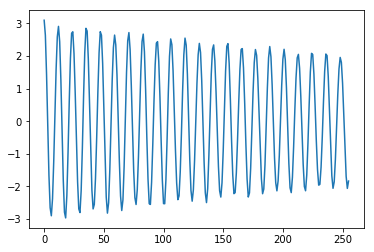

In [161]:
truncated_ace_real = df.ace_real[:256]
plt.plot(truncated_ace_real)

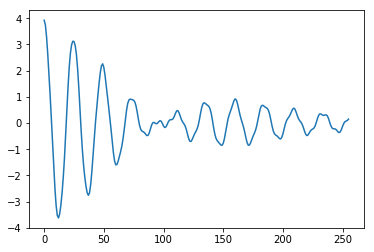

In [162]:
truncated_tau_real = df.tau_real[:256]
plt.plot(truncated_tau_real)

In [163]:
df.columns

Index(['imag_component', 'real_component', 'ace_imag', 'ace_real', 'ala_imag',
       'ala_real', 'asc_imag', 'asc_real', 'asp_imag', 'asp_real', 'cr_imag',
       'cr_real', 'gaba_imag', 'gaba_real', 'glc_imag', 'glc_real', 'gln_imag',
       'gln_real', 'glu_imag', 'glu_real', 'gly_imag', 'gly_real', 'gpc_imag',
       'gpc_real', 'gsh_imag', 'gsh_real', 'ins_imag', 'ins_real', 'lac_imag',
       'lac_real', 'mac_imag', 'mac_real', 'naa_imag', 'naa_real', 'naag_imag',
       'naag_real', 'pcho_imag', 'pcho_real', 'pcr_imag', 'pcr_real',
       'pe_imag', 'pe_real', 'tau_imag', 'tau_real'],
      dtype='object')

In [164]:
def y_t(v_k):
    return (np.random.normal(0,1)*np.exp(complex(0,1)*PHASE_SHIFT)*np.exp(-DAMPING_FACTOR + 2*np.pi*complex(0,1)*DELTA_FREQUENCY)*v_k)

In [165]:
cols =df.columns[2:]
for i in np.arange(len(cols)):
    if i%2!=0:
        print(cols[i])
    else:
        print("Imaginary")

Imaginary
ace_real
Imaginary
ala_real
Imaginary
asc_real
Imaginary
asp_real
Imaginary
cr_real
Imaginary
gaba_real
Imaginary
glc_real
Imaginary
gln_real
Imaginary
glu_real
Imaginary
gly_real
Imaginary
gpc_real
Imaginary
gsh_real
Imaginary
ins_real
Imaginary
lac_real
Imaginary
mac_real
Imaginary
naa_real
Imaginary
naag_real
Imaginary
pcho_real
Imaginary
pcr_real
Imaginary
pe_real
Imaginary
tau_real


In [134]:
cols =df.columns[2:]
def mrs_signal():
    m_signal =[]
    for i in np.arange(len(cols)):
        if i%2!=0:
            col = cols[i]
            col_res =y_t(df[col])
            m_signal.append(col_res)
        else:
            continue
    return np.sum(np.asarray(m_signal))

In [139]:
mrs_signal()

(-0.00023619934247234828-0.0007269468278188288j)

In [166]:
def y_d():
    y_d = mrs_signal() + df.mac_real + np.random.normal(0.0,1.0)
    return (y_d)

In [167]:
y=y_t(df.ace_real)
b_m=y.real
len(b_m)

2048

In [168]:
y=y_d()
y

0         (20.072745403558383+0.002334211854638746j)
1          (34.80484540355838+0.002334211854638746j)
2         (21.270445403558384+0.002334211854638746j)
3          (4.244395403558382+0.002334211854638746j)
4        (-10.845254596441617+0.002334211854638746j)
5        (-19.778354596441616+0.002334211854638746j)
6        (-20.907954596441616+0.002334211854638746j)
7        (-15.450654596441618+0.002334211854638746j)
8        (-6.6385645964416184+0.002334211854638746j)
9          (1.726175403558382+0.002334211854638746j)
10         (6.790995403558382+0.002334211854638746j)
11        (7.5100854035583815+0.002334211854638746j)
12         (4.681765403558382+0.002334211854638746j)
13       (0.23969240355838217+0.002334211854638746j)
14        (-3.757154596441618+0.002334211854638746j)
15        (-5.983474596441618+0.002334211854638746j)
16        (-6.215574596441618+0.002334211854638746j)
17        (-5.139424596441618+0.002334211854638746j)
18       (-3.7922345964416184+0.00233421185463

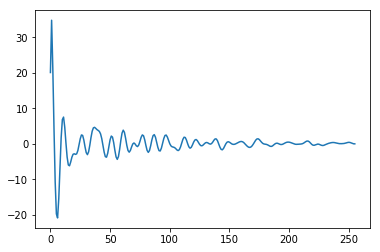

In [169]:
plt.plot(y.real[:256])

In [ ]:
X = tf.placeholder(dtype =tf.float32, shape =(None,2048))
X= y_d()

In [170]:
def get_model():
    model = Sequential()
    model.add(InputLayer(input_tensor=X, input_shape=(2048,)))
    model.add(Conv2D(16, (2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('crelu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('crelu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3)))
    model.add(Activation('crelu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(21))
    model.add(Activation('linear'))

    model.compile(loss='mean_squared_error',
                optimizer='sgd',
                metrics=['accuracy'])
    return model

NameError: name 'tf' is not defined